## comportamiento de la banda en funcion del tiempo

Este modo de operacion calcula los espectrogramas 

In [221]:
import psycopg2
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
#%matplotlib notebook
%matplotlib inline

def promedio(espectro, nfft):
    """ Realiza promedios del espectro,
    debido a que las muestras estan almacenadas en un vector de tamano N
    que se subdivide N/nfft veces y ese es el numero que se promedia (K)"""
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x   

1) seleccionar banda espectral

2) extraer espectro y extraer fechas

3) crear la matriz espectro, tiempo, frecuencia



In [238]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

## 1) extraccion de espectros

In [256]:
frec_central = [86000000,]
nfft = 1024
frec_muestreo = 16000000
query1 = "SELECT espectro, fecha FROM radioastronomia_espectro WHERE (frec_central = "+str(frec_central[0])+ "AND nfft="+str(nfft)+ " AND frec_muestreo="+str(frec_muestreo)+");"
print(query1)

SELECT espectro, fecha FROM radioastronomia_espectro WHERE (frec_central = 86000000AND nfft=1024 AND frec_muestreo=16000000);


In [257]:
cur.execute(query1)
rows = cur.fetchall()
print(len(rows))

7


In [258]:
espectrograma = pd.DataFrame(columns=["frecuencia", "tiempo", "espectro"])
k = 0
char_ener = []
tiempo = []
for row in rows:
    #este ciclo es la dimension del tiempo
    espectro = row[0]
    fecha = row[1]
    espectro = numpy.asarray(espectro)
    #promedio los espectros por cada tiempo escogido
    espectro = promedio(espectro=espectro, nfft=nfft)
    char_ener.append(numpy.sum(10**(espectro/10)))
    tiempo.append(fecha.strftime('%d %H:%M:%S'))
    f = numpy.arange(-int(nfft/2),int(nfft/2),1)*frec_muestreo/(nfft*2) + frec_central[0]
    for i in range(nfft):
        espectrograma.loc[k] = [f[i]/1e6, fecha.strftime('%m-%d %H:%M:%S'), espectro[i]]
        k = k + i
df = espectrograma.pivot("tiempo", "frecuencia", "espectro")

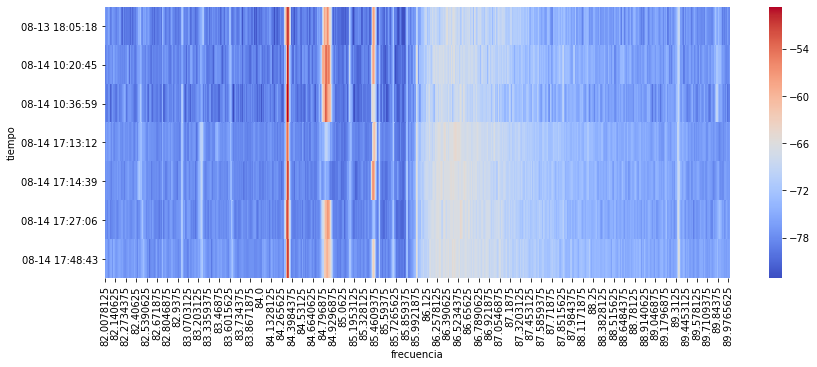

In [259]:
plt.figure(figsize=(14,5))
df = espectrograma.pivot("tiempo", "frecuencia", "espectro")
sns.heatmap(df, cmap="coolwarm")

In [260]:
print(char_ener)

[8.661063555149022e-05, 0.00010067115210573862, 9.794844522691327e-05, 6.950100901311813e-05, 8.090732858634664e-05, 8.819431301968006e-05, 8.875749566019811e-05]


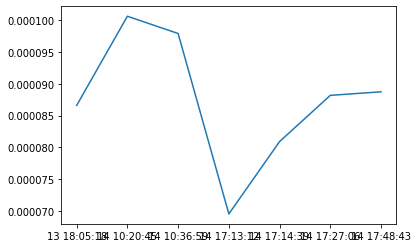

In [261]:
plt.plot(tiempo, char_ener)

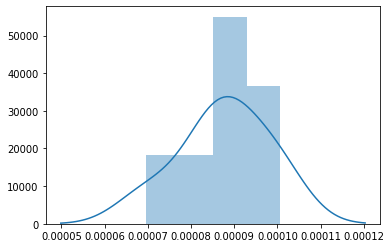

In [262]:
sns.distplot(char_ener)

In [232]:
conn.close()